In [1]:
from numpy.linalg import inv
import numpy as np
import matplotlib.pyplot as plt
import math
from math import e
from math import log
from numpy import linalg
import sys
import sympy
from sympy import *
from IPython.display import display, HTML
import random

%matplotlib inline
%config IPCompleter.greedy=True
sympy.init_printing(use_unicode=False, wrap_line=True)
np.set_printoptions(suppress=True)

In [2]:
def CLT_std_norm_rand():
    random_nums = [random.uniform(0, 1) for x in range(12)] 
    std_norm_rand = sum(random_nums) - 6
    return std_norm_rand

def gaussian_data_generator(mean, var, method=0):
    if method==0:
        std_norm_rand = CLT_std_norm_rand()
    norm_rand = mean + (std_norm_rand * var**(1/2))
    return norm_rand

def plot_data(D1, D2):
    xs_1 = [x for x,y,b in D1]
    ys_1 = [y for x,y,b in D1]
    xs_2 = [x for x,y,b in D2]
    ys_2 = [y for x,y,b in D2]
    plt.scatter(xs_1, ys_1, color='blue', marker='o')
    plt.scatter(xs_2, ys_2, color='red', marker='o')
    
    # plt.show()

def plot_decision_boundary(theta):
    w1, w2, w0 = theta
    xs = np.linspace(-10, 10, 100)
    ys = [ np.asscalar((-w0-w1*x1)/w2) for x1 in xs]
    
    plt.plot(xs, ys, label='Decision Boundary')
    ys_upper = [ y+1000 for y in ys]
    ys_lower = [ y-1000 for y in ys]
    
    plt.plot(xs, ys_upper, c = "g")
    plt.plot(xs, ys_lower, c = 'r')

    plt.fill_between(xs, ys, ys_upper, facecolor = "red", alpha=0.1)
    plt.fill_between(xs, ys, ys_lower, facecolor = "blue", alpha=0.1)
    #plt.legend()

In [3]:
def is_nan(x):
    return (x is np.nan or x != x or math.isnan(float(x)))

def logistic_function(z):
    e = math.e
    return 1 / (1 + e**(-z) )

def prediction(x, w):
    z = np.asscalar(np.matmul(w.T, x))
    return logistic_function(z)

def evaluation(X,Y,theta):
    n_correct, n_total = 0, 0
    for x, y in zip(X,Y):
        x_ = np.array(x, ndmin=2).reshape(num_basis, 1)
        pred = prediction(x_, theta)
        if int(pred>=0.5) == y:
            n_correct += 1
        n_total += 1
    return n_correct / n_total


def hession(X, w):
    D = np.zeros((len(X), len(X)))
    for d in range(len(X)):
        x = np.array(X[d], ndmin=2).reshape(num_basis, 1)
        z = np.asscalar(np.matmul(w.T, x))
        D[d][d] = e**(-z) / ((1+e**(-z))**2)
    A = np.array(X)
    return np.matmul(np.matmul(A.T, D), A)

def gradient(X, Y, theta):
    predictions = []
    for x in X:
        x = np.array(x, ndmin=2).reshape(num_basis, 1)
        predictions.append(prediction(x, theta))
    X = np.reshape(X, (len(X), 3))
    Y = np.reshape(Y, (len(Y), 1))
    predictions = np.reshape(predictions, (len(Y), 1))
    return np.matmul(X.T, predictions-Y)

def compute_loss(X, Y, theta):
    loss = 0
    for x, y in zip(X,Y):
        y_pred = prediction(x, theta)
        l = -1*(y*log(y_pred) + (1-y)*log(1-y_pred))
        if not is_nan(l):
            loss += -1*(y*log(y_pred) + (1-y)*log(1-y_pred))
    if is_nan(loss/len(X)):
        print(loss)
    return loss / len(X)
        
    
def logistic_optimization(X, Y, theta, lr=0.1, max_epochs=10, batch_size=100):
    X = np.array(X)
    Y = np.array(Y)
    best_loss = 100
    for epoch in range(max_epochs):
        print('#### epoch : %d #### (lr=%g)' %(epoch+1, lr))
        order = [i for i in range(len(X))]
        order = np.random.permutation(order)
        for i in range(0, len(order), batch_size):
            indexes = order[i:i+batch_size] if i+batch_size < len(order) else order[i:]
            X_sample = X[indexes]
            Y_sample = Y[indexes]
            h = hession(X_sample, theta)
            g = gradient(X_sample, Y_sample, theta)
            if linalg.cond(h) < 1/sys.float_info.epsilon: 
                # if hession is invertible, use newton's method
                h_inv = linalg.inv(h)
                theta = theta - lr * np.matmul(h_inv, g)
            else:
                # if hession is not invertible, use gradient descent
                theta = theta - lr * g
        loss = compute_loss(X, Y, theta)
        print('Loss : %.8f'% (loss))
        print('Acc : %.2f'% (evaluation(X,Y,theta)*100))
        if loss >= best_loss:
            lr = lr * 0.1
            if lr < 0.001:
                print('\nConverge after %d epoch' %(epoch+1))
                break
        else:
            best_loss = loss
    return theta

In [4]:
# Ground Truth
mx1 = 0
my1 = 0
vx1 = 1
vy1 = 1

mx2 = 5
my2 = 5
vx2 = 1
vy2 = 1

# Generate Data
num_points = 1000
D1 = []
D2 = []
for i in range(num_points):
    x1 = gaussian_data_generator(mean=mx1, var=vx1)
    y1 = gaussian_data_generator(mean=my1, var=vy1)
    D1.append([x1, y1, 1]) # add bais term
    x2 = gaussian_data_generator(mean=mx2, var=vx2)
    y2 = gaussian_data_generator(mean=my2, var=vy2)
    D2.append([x2, y2, 1]) # add bias term

In [5]:
w = [0, 0, 0] # init of theta
num_basis = len(w)
theta = np.array(w, ndmin=2).reshape(num_basis, 1)

X = [point for point in D1] + [point for point in D2]
Y = [0 for i in range(len(D1))] + [1 for i in range(len(D2))]

h = hession(X, theta)
theta_newton = logistic_optimization(X, Y, theta, lr=0.1, max_epochs=100, batch_size=128)

#### epoch : 1 #### (lr=0.1)
Loss : 0.12571368
Acc : 100.00
#### epoch : 2 #### (lr=0.1)
Loss : 0.02992434
Acc : 100.00
#### epoch : 3 #### (lr=0.1)
Loss : 0.00783297
Acc : 100.00
#### epoch : 4 #### (lr=0.1)
Loss : 0.00251698
Acc : 100.00
#### epoch : 5 #### (lr=0.1)
Loss : 0.00096026
Acc : 100.00
#### epoch : 6 #### (lr=0.1)
Loss : 0.00049104
Acc : 100.00
#### epoch : 7 #### (lr=0.1)
Loss : 0.00030872
Acc : 100.00
#### epoch : 8 #### (lr=0.1)
Loss : 0.00020872
Acc : 100.00
#### epoch : 9 #### (lr=0.1)
Loss : 0.00015680
Acc : 100.00
#### epoch : 10 #### (lr=0.1)
Loss : 0.00012140
Acc : 100.00
#### epoch : 11 #### (lr=0.1)
Loss : 0.00009565
Acc : 100.00
#### epoch : 12 #### (lr=0.1)
Loss : 0.00007146
Acc : 100.00
#### epoch : 13 #### (lr=0.1)
Loss : 0.00005526
Acc : 100.00
#### epoch : 14 #### (lr=0.1)
Loss : 0.00004250
Acc : 100.00
#### epoch : 15 #### (lr=0.1)
Loss : 0.00003289
Acc : 100.00
#### epoch : 16 #### (lr=0.1)
Loss : 0.00002808
Acc : 100.00
#### epoch : 17 #### (lr=0.1)
Los

Loss : 0.00
Acc : 100.00


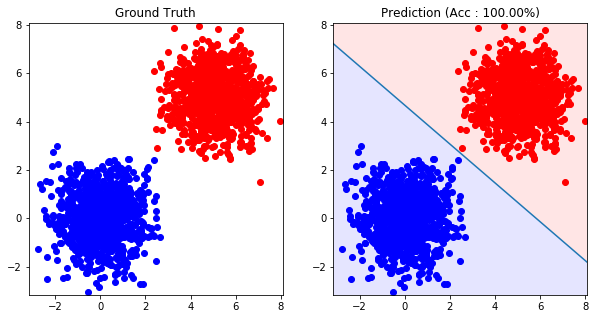

In [6]:
print('Loss : %.2f'% (compute_loss(X, Y, theta_newton)))
print('Acc : %.2f'% (evaluation(X,Y,theta_newton)*100))
plt.figure(figsize=(10,5))

# Plot Ground Truth
plt.subplot(121)
plt.title('Ground Truth')
plot_data(D1, D2)
plt.ylim(np.min(X)-0.1, np.max(X)+0.1)
plt.xlim(np.min(X)-0.1, np.max(X)+0.1)

# Plot Prediction
plt.subplot(122)
plt.title('Prediction (Acc : %.2f%%)'%(evaluation(X,Y,theta_newton)*100))
plot_data(D1, D2)
plot_decision_boundary(theta_newton)
plt.ylim(np.min(X)-0.1, np.max(X)+0.1)
plt.xlim(np.min(X)-0.1, np.max(X)+0.1)
plt.show()